In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
# import wandb
from timm import create_model
from einops import rearrange, reduce
from sklearn.metrics import accuracy_score, f1_score
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter, Normalize, Compose, RandomAffine

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
output_dir = '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [6]:
from multiplex_imaging_pipeline.region_classification import RegionImgTransform, RegionDataset, RegionClassifier, ModelLightning


In [7]:
torch.cuda.is_available()

False

In [19]:
pred_ds = torch.load(os.path.join(output_dir, 'classification_model_datasets', 'prediction.pt'))

In [8]:
train_ds = torch.load(os.path.join(output_dir, 'classification_model_datasets', 'train.pt'))

In [9]:
val_ds = torch.load(os.path.join(output_dir, 'classification_model_datasets', 'val.pt'))

In [10]:
len(train_ds), len(val_ds)

(509, 128)

In [11]:
509 + 128

637

In [37]:
batch_size = 128
pred_dl = DataLoader(pred_ds, batch_size=batch_size, num_workers=1)

In [18]:
d = pred_ds[100]
d.keys()

dict_keys(['mask', 'rgb', 'y'])

In [19]:
d['rgb'].dtype, d['mask'].dtype, d['y'].shape

(torch.float32, torch.float32, torch.Size([1]))

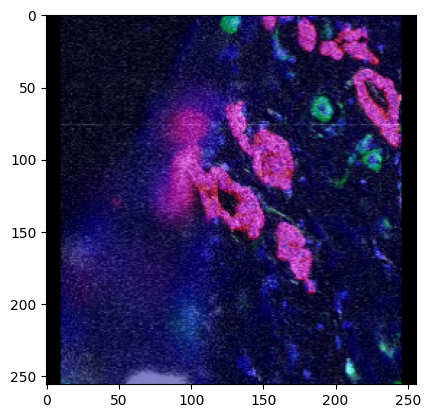

In [20]:
img = rearrange(d['rgb'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

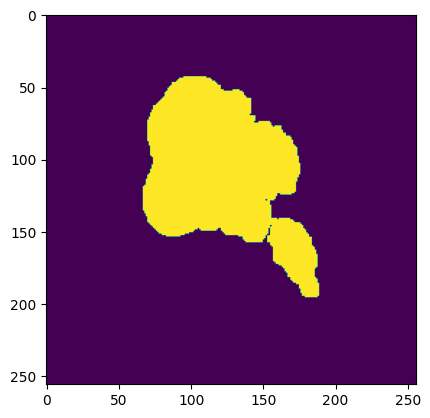

In [21]:
plt.imshow(d['mask'][0])

In [22]:
d['y']

tensor([1.])

## training model

In [26]:
trainer = pl.Trainer(
    accelerator='cpu',
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
best = ModelLightning.load_from_checkpoint(
    '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/classification_model/epoch=499-step=8000.ckpt',
    map_location=torch.device('cpu')
)


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [38]:
result = trainer.predict(best, dataloaders=pred_dl)

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/shutil.py", line 708, in rmtree
    _rmtree_safe_fd(fd, path, onerror)
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/shutil.py", line 665, in _rmtree_safe_fd
    onerror(os.unlink, fullname, sys.exc_info())
  File "/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/shutil.py", line 663, in _rmtree_safe_fd
    os.unlink(entry.name, dir_fd=topfd)
OSError: [Errno 16] Device or 

In [39]:
probs = result[0]
for x in result[1:]:
    probs = torch.concat((probs, x), dim=0)
probs.shape

torch.Size([12513, 4])

In [40]:
df = pd.DataFrame(data=probs.detach().cpu().numpy(), columns=train_ds.labels, index=pred_ds.keys)
df.index.name = 'region_id'
df

,artifact,dcis,idc,normal
region_id,,,,
HT110B1_S1H4_1,0.000062,0.000183,0.054832,0.944923
HT110B1_S1H4_10,0.000099,0.002608,0.902236,0.095058
HT110B1_S1H4_100,0.000012,0.000248,0.998725,0.001015
HT110B1_S1H4_101,0.000039,0.001245,0.991898,0.006818
HT110B1_S1H4_102,0.000112,0.002230,0.857228,0.140430
...,...,...,...,...
HT565B1-S1H2_U2_07012023_95,0.000005,0.000024,0.980344,0.019627
HT565B1-S1H2_U2_07012023_96,0.000002,0.000007,0.993212,0.006779
HT565B1-S1H2_U2_07012023_97,0.000008,0.000043,0.990748,0.009201


In [41]:
out = os.path.join(output_dir, 'classification_model_predictions')
Path(out).mkdir(parents=True, exist_ok=True)
df.to_csv(os.path.join(out, 'probs.txt'), sep='\t')

#### export labeling file for label studio

In [29]:
import json

In [30]:
out = os.path.join(output_dir, 'classification_model_predictions')
df = pd.read_csv(os.path.join(out, 'probs.txt'), sep='\t', index_col=0)
df['sample_id'] = ['_'.join(x.split('_')[:-1]) for x in df.index]
df['predicted_label'] = [train_ds.labels[i] for i in np.argmax(df[train_ds.labels].values, axis=1)]
df = df.sort_values(['sample_id', 'predicted_label'])
df

,artifact,dcis,idc,normal,sample_id,predicted_label
region_id,,,,,,
HT110B1_S1H4_108,0.000046,0.995500,0.002110,0.002345,HT110B1_S1H4,dcis
HT110B1_S1H4_140,0.000328,0.558524,0.004525,0.436623,HT110B1_S1H4,dcis
HT110B1_S1H4_147,0.000330,0.809600,0.157995,0.032075,HT110B1_S1H4,dcis
HT110B1_S1H4_155,0.000081,0.985948,0.010057,0.003914,HT110B1_S1H4,dcis
HT110B1_S1H4_204,0.000070,0.974752,0.001848,0.023329,HT110B1_S1H4,dcis
...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_99,0.000307,0.149647,0.837669,0.012377,HT565B1-S1H2_U2_07012023,idc
HT565B1-S1H2_U2_07012023_115,0.000030,0.000093,0.175036,0.824841,HT565B1-S1H2_U2_07012023,normal
HT565B1-S1H2_U2_07012023_18,0.000229,0.001117,0.131918,0.866736,HT565B1-S1H2_U2_07012023,normal


In [58]:
save_dir = os.path.join(output_dir, 'label_fixing', 'images')
Path(save_dir).mkdir(parents=True, exist_ok=True)
dataset = []
for region in df.index.to_list():
    i = pred_ds.keys.index(region)
    d = pred_ds[i]
    label = df.loc[region, 'predicted_label']
    
    fig, axs = plt.subplots(ncols=2)
    img = rearrange(d['rgb'], 'c h w -> h w c')
    img -= img.min()
    img /= img.max()
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(label)

    mask = d['mask'][0]
    axs[1].imshow(mask)
    axs[1].axis('off')
    axs[1].set_title(region)
    
    filepath = os.path.join(save_dir, f'{label}_{region}.jpeg')
    plt.savefig(filepath)
    plt.close()
    
    data = {
        'data': {
#             'image': f'http://localhost:8081/{region}.jpeg',
            'image': os.path.join('~/Documents/ding/region_labeling/brca_subtype/label_fixing/images', f'{label}_{region}.jpeg'),
            'ref_id': region,
            'meta_info': {
                'region': region,
                'pre-classification': label,
                'sample': df.loc[region, 'sample_id']
            }
        },
        'predictions': [
            {'result': label}
        ]
#         'annotations': [{
#             'result': [{

#                 'type': 'choices',
#                 "readonly": False,
#                 "hidden": False,
#                 "value": {
#                     "choices": [label]
#                 }
#             }]
#         }],
    }
    dataset.append(data)
    
    

In [57]:
# json.dump(dataset, open(os.path.join(output_dir, 'label_fixing', 'dataset.json'), 'w'))

In [ ]:
## just load into label software as images, it's easier and couldn't get the json thing with metadata to work

#### fix annotations

In [59]:
out = os.path.join(output_dir, 'classification_model_predictions')
df = pd.read_csv(os.path.join(out, 'probs.txt'), sep='\t', index_col=0)
df['sample_id'] = ['_'.join(x.split('_')[:-1]) for x in df.index]
df['predicted_label'] = [train_ds.labels[i] for i in np.argmax(df[train_ds.labels].values, axis=1)]
df = df.sort_values(['sample_id', 'predicted_label'])
df

,artifact,dcis,idc,normal,sample_id,predicted_label
region_id,,,,,,
HT110B1_S1H4_108,0.000046,0.995500,0.002110,0.002345,HT110B1_S1H4,dcis
HT110B1_S1H4_140,0.000328,0.558524,0.004525,0.436623,HT110B1_S1H4,dcis
HT110B1_S1H4_147,0.000330,0.809600,0.157995,0.032075,HT110B1_S1H4,dcis
HT110B1_S1H4_155,0.000081,0.985948,0.010057,0.003914,HT110B1_S1H4,dcis
HT110B1_S1H4_204,0.000070,0.974752,0.001848,0.023329,HT110B1_S1H4,dcis
...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_99,0.000307,0.149647,0.837669,0.012377,HT565B1-S1H2_U2_07012023,idc
HT565B1-S1H2_U2_07012023_115,0.000030,0.000093,0.175036,0.824841,HT565B1-S1H2_U2_07012023,normal
HT565B1-S1H2_U2_07012023_18,0.000229,0.001117,0.131918,0.866736,HT565B1-S1H2_U2_07012023,normal


In [60]:
from multiplex_imaging_pipeline.utils import listfiles

In [61]:
fps = sorted(listfiles(os.path.join(output_dir, 'label_fixing', 'annotations'), regex='.json$'))
fps

['/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/b1_annotations.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/idc_ht30x.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/idc_ht32-3.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/idc_ht34-9.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/idc_ht4-5.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/normal_ht1-2.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotations/normal_ht3_p1.json',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/label_fixing/annotat

In [71]:
region_to_label = {}
for fp in fps:
    d = json.load(open(fp))
    for entry in d:
        annot = entry['annotations'][0]
        if annot['result']:
            label = annot['result'][0]['value']['choices'][0]
            root = entry['data']['image'].split('/')[-1]
            region = root.replace('.jpeg', '')
            region = '_'.join(region.split('_')[1:])
            region_to_label[region] = label
        

In [76]:
region_to_label.update(
    {
        'HT565B1-S1H2_U2_07012023_1': 'artifact',
        'HT271B1-S1H6A5_left_05122023_1': 'artifact',
        'HT206B1-S1H5_U2_07012023_11': 'artifact',
        'HT171B1-S1H9A1-4_right_05122023_62': 'artifact',
    }
)

In [72]:
region_to_label

{'HT110B1_S1H4_140': 'normal',
 'HT110B1_S1H4_147': 'idc',
 'HT110B1_S1H4_204': 'normal',
 'HT171B1-S1H9A1-4_left_05122023_14': 'idc',
 'HT171B1-S1H9A1-4_left_05122023_3': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_126': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_130': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_139': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_148': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_164': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_172': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_77': 'idc',
 'HT171B1-S1H9A1-4_right_05122023_79': 'idc',
 'HT171B1-S1H9A1-A4_left_05262023_10': 'idc',
 'HT171B1-S1H9A1-A4_right_05262023_54': 'idc',
 'HT171B1-S1H9A1-A4_right_05262023_67': 'idc',
 'HT171B1-S1H9A1-A4_right_05262023_70': 'idc',
 'HT206B1-S1H5_U1_07012023_15': 'idc',
 'HT206B1-S1H5_U1_07012023_25': 'other',
 'HT206B1-S1H5_U1_07012023_31': 'other',
 'HT206B1-S1H5_U1_07012023_38': 'normal',
 'HT206B1-S1H5_U2_07012023_13': 'normal',
 'HT206B1-S1H5_U2_07012023_19': 'normal',
 'HT206B1-S1H

In [77]:
df['revised_label'] = [region_to_label.get(x, label) for x, label in zip(df.index, df['predicted_label'])]
df

,artifact,dcis,idc,normal,sample_id,predicted_label,revised_label
region_id,,,,,,,
HT110B1_S1H4_108,0.000046,0.995500,0.002110,0.002345,HT110B1_S1H4,dcis,dcis
HT110B1_S1H4_140,0.000328,0.558524,0.004525,0.436623,HT110B1_S1H4,dcis,normal
HT110B1_S1H4_147,0.000330,0.809600,0.157995,0.032075,HT110B1_S1H4,dcis,idc
HT110B1_S1H4_155,0.000081,0.985948,0.010057,0.003914,HT110B1_S1H4,dcis,dcis
HT110B1_S1H4_204,0.000070,0.974752,0.001848,0.023329,HT110B1_S1H4,dcis,normal
...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_99,0.000307,0.149647,0.837669,0.012377,HT565B1-S1H2_U2_07012023,idc,dcis
HT565B1-S1H2_U2_07012023_115,0.000030,0.000093,0.175036,0.824841,HT565B1-S1H2_U2_07012023,normal,artifact
HT565B1-S1H2_U2_07012023_18,0.000229,0.001117,0.131918,0.866736,HT565B1-S1H2_U2_07012023,normal,artifact


In [78]:
out = os.path.join(output_dir, 'classification_model_predictions')
df.to_csv(os.path.join(out, 'revised_labels.txt'), sep='\t')

In [79]:
out = os.path.join(output_dir, 'label_fixing')
df.to_csv(os.path.join(out, 'revised_labels.txt'), sep='\t')